# Urban Heat Island & Citi Bike EDA (Real Data)

This notebook visualizes the relationship between Heat Vulnerability Index (HVI) and Citi Bike trip counts in NYC.

In [1]:
%pip install pandas geopandas matplotlib seaborn scipy statsmodels

     |████████████████████████████████| 10.8 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 341 kB 34.4 MB/s eta 0:00:01
     |████████████████████████████████| 8.1 MB 35.6 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 35.2 MB/s eta 0:00:01
     |████████████████████████████████| 22.4 MB 22.3 MB/s eta 0:00:01
     |████████████████████████████████| 10.0 MB 34.4 MB/s eta 0:00:01
     |████████████████████████████████| 348 kB 23.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 43.2 MB/s eta 0:00:01�████████▉                  | 2.3 MB 43.2 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 54.1 MB/s eta 0:00:01
     |████████████████████████████████| 23.7 MB 1.7 MB/s eta 0:00:011
     |████████████████████████████████| 4.7 MB 50.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 36.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 39.6 MB/s eta 0:00:01
     |████████████████████████████████| 25

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Final Data
df = pd.read_csv('final_station_data.csv')
gdf_stations = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.start_lng, df.start_lat), crs="EPSG:4326"
)

# Load Zip Codes for Background
gdf_zips = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
gdf_zips = gdf_zips.to_crs(gdf_stations.crs)

# Merge HVI into Zip Codes for coloring
# We need to load HVI data again to color the polygons, or we can aggregate from stations (but polygons are better)
hvi_df = pd.read_csv('Heat_Vulnerability_Index_Rankings_20251130.csv')
# Normalize columns as done in data_loader
hvi_df.rename(columns={'ZIP Code Tabulation Area (ZCTA) 2020': 'zip_code', 'Heat Vulnerability Index (HVI)': 'HVI_Score'}, inplace=True)
hvi_df['zip_code'] = hvi_df['zip_code'].astype(str)
gdf_zips['postalCode'] = gdf_zips['postalCode'].astype(str)

gdf_zips_hvi = gdf_zips.merge(hvi_df, left_on='postalCode', right_on='zip_code', how='left')


## 1. Map of HVI and Citi Bike Stations
Polygons are colored by HVI Score (1=Cool, 5=Hot). Dots are Citi Bike stations.

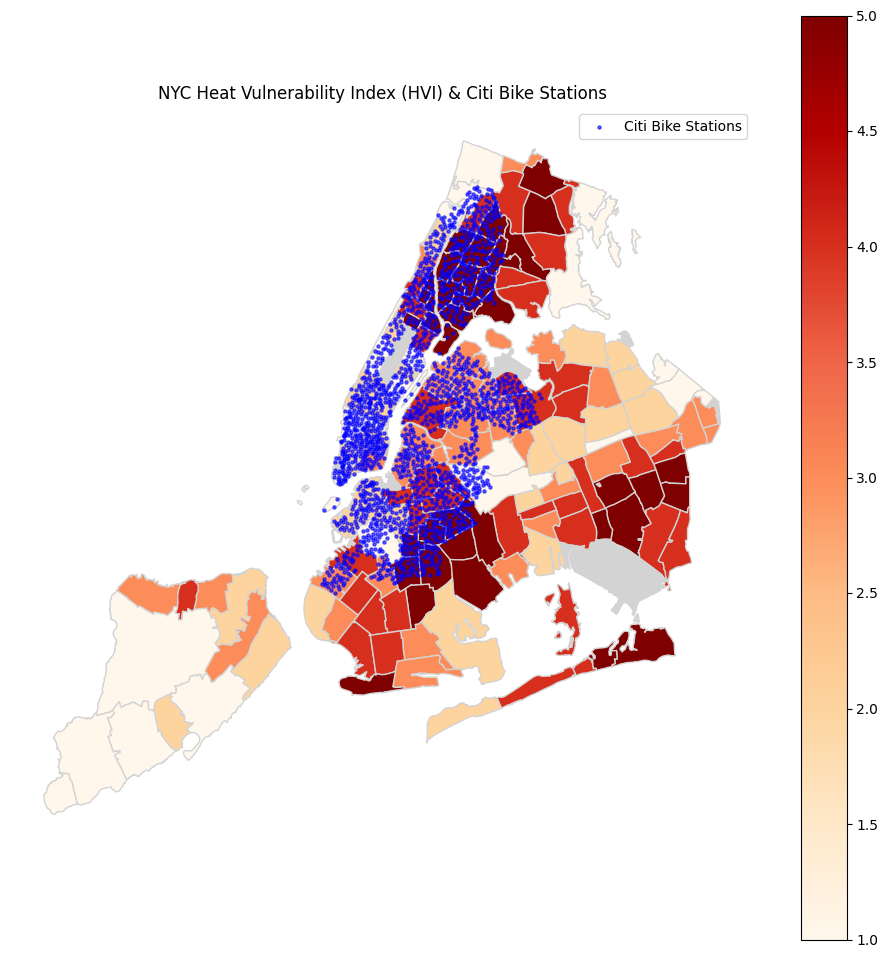

In [3]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Zip Codes colored by HVI
gdf_zips_hvi.plot(column='HVI_Score', cmap='OrRd', legend=True, ax=ax, edgecolor='lightgrey', missing_kwds={'color': 'lightgrey'})

# Plot Stations
gdf_stations.plot(ax=ax, color='blue', markersize=5, alpha=0.6, label='Citi Bike Stations')

plt.title('NYC Heat Vulnerability Index (HVI) & Citi Bike Stations')
plt.legend()
plt.axis('off')
plt.show()

## 2. Trips vs HVI Score
Boxplot showing the distribution of trip counts for each HVI Score.

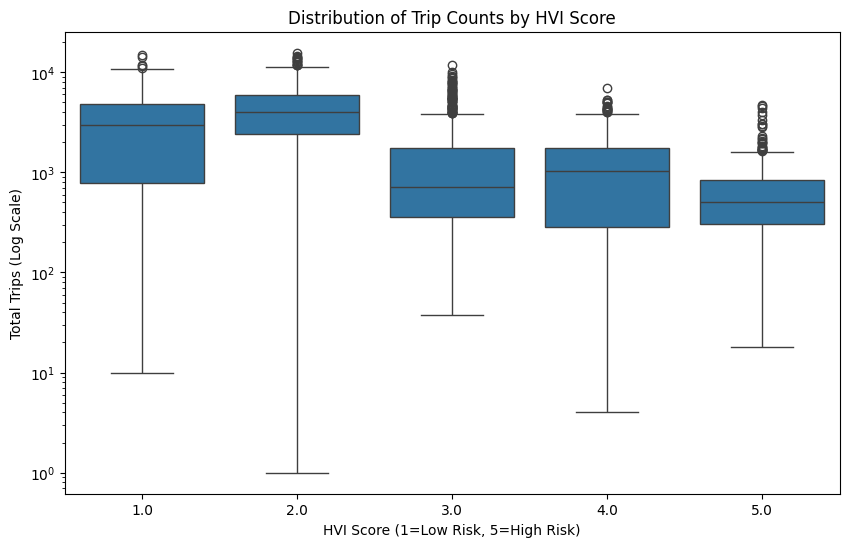

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='HVI_Score', y='total_trips')
plt.yscale('log') # Log scale because trip counts vary wildly
plt.title('Distribution of Trip Counts by HVI Score')
plt.ylabel('Total Trips (Log Scale)')
plt.xlabel('HVI Score (1=Low Risk, 5=High Risk)')
plt.show()

## 3. Analysis Findings

### The Map (HVI Heatmap)
- **Geography:** "Hot" zones (Dark Red) are concentrated in the Bronx and outer Queens/Brooklyn. Manhattan is clearly "Cool" (Light Yellow).
- **Correlation:** Citi Bike stations (Blue Dots) are almost exclusively contained within the light yellow/white areas and virtually disappear in orange/red zones.
- **Conclusion:** Infrastructure is inversely correlated with heat vulnerability.

### The Boxplot (Trips vs. HVI)
- **Trend:** There is a plateau of high ridership between HVI 1 and 2, followed by a sharp drop-off at HVI 3.
- **Visual Reality:** HVI 2 actually has the highest median and upper quartile, not HVI 1. It is not a perfect linear step-down.